# Бинарный классификатор

## Описание датасета

Согласно варианту в ходе работы используем датасет [«Оценка вероятности диагностики диабета у человека»](https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset). В данном датасете имеется обезличенная информация о пациентах, а также метка диабета, состоящая их трёх значений: 0 (нет диабета), 1 (преддиабет) и 2 (диабет). Поскольку по заданию необходимо реализовать бинарный классификатор, то классы 1 и 2 будут объеденены в один. Для загрузки датасета с kaggle установим их API.

In [3]:
pip install kaggle

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 173 kB 518 kB/s eta 0:00:01
     |████████████████████████████████| 78 kB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 128 kB 4.7 MB/s eta 0:00:01
     |████████████████████████████████| 417 kB 3.8 MB/s eta 0:00:01
     |████████████████████████████████| 166 kB 7.3 MB/s eta 0:00:01
     |████████████████████████████████| 163 kB 10.8 MB/s eta 0:00:01
     |████████████████████████████████| 197 kB 4.3 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 70 kB 5.4 MB/s eta 0:00:01
  Using cached requests-2.32.3-py3-none-any.whl (64 kB)
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Можно вписать свои данные через os.environ, а можно просто поместить kaggle.json в нужную директорию, в данной работе используется второй вариант.

In [ ]:
# import os
# os.environ['KAGGLE_USERNAME'] = "USERNAME" # username from the json file
# os.environ['KAGGLE_KEY'] = "KEY" # key from the json file

In [ ]:
import kaggle

dataset_name = "alexteboul/diabetes-health-indicators-dataset"

# download and unzip to current folder
kaggle.api.dataset_download_files(dataset_name, path="./", unzip=True)


Dataset URL: https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset


In [4]:
import pandas as pd

df = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')
df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


Далее выполним замену трёх классов на два

In [ ]:
print(df['Diabetes_012'].value_counts()) # show the total number of values for each class
df['Diabetes_012'] = df['Diabetes_012'].apply(lambda x: 1 if x > 0 else 0) # leave only 2 classes
print(f"New column:\n{df['Diabetes_012'].value_counts()}") # show the total number of values for each class

Diabetes_012
0.0    213703
2.0     35346
1.0      4631
Name: count, dtype: int64
New column:
Diabetes_012
0    213703
1     39977
Name: count, dtype: int64


Разделим датасет в соотношении 80/20

In [ ]:
from sklearn.model_selection import train_test_split 

y = df['Diabetes_012']
X = df.drop(['Diabetes_012'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42) # 80% to train and 20% to test
print(f'X_train shape: {X_train.shape}\n y_train shape: {y_train.shape}\n X_test shape: {X_test.shape}\n y_test shape: {y_test.shape}')

X_train shape: (202944, 21)
 y_train shape: (202944,)
 X_test shape: (50736, 21)
 y_test shape: (50736,)


Здесь мы задаём fit у MinMaxScaler только на обучающей выборке, чтобы информация от тестовой выборки не просачилась в обучение.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()

# put everything to [0;1] range
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

И собираем тензоры для PyTorch

In [ ]:
import torch

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

## Создание модели

In [ ]:
import torch

class BinaryClassificatorModel(torch.nn.Module):
    def __init__(self):
        super(BinaryClassificatorModel, self).__init__()
        self.model = torch.nn.Sequential( 
            torch.nn.Linear(21, 64), # fully-connected layer (like «Dense» from Tensorflow)
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,128),
            torch.nn.Linear(128, 1),
            torch.nn.Sigmoid() # sigmoid to make [0;1] prediction
        )
    
    def forward(self, x):
        return self.model(x)


## Обучение модели

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# hyper-parameters
batch_size = 32
num_epochs = 100
learning_rate = 0.001

model = BinaryClassificatorModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        # Feedforward
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

with torch.no_grad():
    y_pred_test = model(X_test)
    y_pred_labels = (y_pred_test >= 0.5).float()  # from [0;1] to (0,1)
    accuracy = (y_pred_labels == y_test).float().mean()

print(f"Test Accuracy: {accuracy:.4f}")

Epoch [1/100], Loss: 0.3688
Epoch [2/100], Loss: 0.3422
Epoch [3/100], Loss: 0.5204
Epoch [4/100], Loss: 0.2530
Epoch [5/100], Loss: 0.3579
Epoch [6/100], Loss: 0.3647
Epoch [7/100], Loss: 0.3359
Epoch [8/100], Loss: 0.3889
Epoch [9/100], Loss: 0.1933
Epoch [10/100], Loss: 0.2674
Epoch [11/100], Loss: 0.5642
Epoch [12/100], Loss: 0.3286
Epoch [13/100], Loss: 0.3091
Epoch [14/100], Loss: 0.4413
Epoch [15/100], Loss: 0.2895
Epoch [16/100], Loss: 0.2739
Epoch [17/100], Loss: 0.2589
Epoch [18/100], Loss: 0.4388
Epoch [19/100], Loss: 0.2067
Epoch [20/100], Loss: 0.3015
Epoch [21/100], Loss: 0.4057
Epoch [22/100], Loss: 0.4158
Epoch [23/100], Loss: 0.3303
Epoch [24/100], Loss: 0.2660
Epoch [25/100], Loss: 0.4224
Epoch [26/100], Loss: 0.4007
Epoch [27/100], Loss: 0.2374
Epoch [28/100], Loss: 0.2183
Epoch [29/100], Loss: 0.3410
Epoch [30/100], Loss: 0.4001
Epoch [31/100], Loss: 0.4817
Epoch [32/100], Loss: 0.4191
Epoch [33/100], Loss: 0.3538
Epoch [34/100], Loss: 0.3749
Epoch [35/100], Loss: 0

## Расчёт метрик

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc


with torch.no_grad():
    y_pred_test = model(X_test)
    y_pred_labels = (y_pred_test >= 0.5).float()  

    
    y_true = y_test.numpy().flatten() 
    y_pred = y_pred_labels.numpy().flatten() 

    # tn = true negative
    # fp = false positive
    # fn = false negative
    # tp = true positive
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Метрики
    TPR = tp / (tp + fn)  # True Positive Rate
    FPR = fp / (fp + tn)  # False Positive Rate
    TNR = tn / (tn + fp)  # True Negative Rate
    FNR = fn / (fn + tp)  # False Negative Rate

    print(f"TPR: {TPR:.4f}, FPR: {FPR:.4f}, TNR: {TNR:.4f}, FNR: {FNR:.4f}")

    # ROC curve and AUROC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_test.numpy().flatten())
    roc_auc = auc(fpr, tpr)

    print(f"AUROC: {roc_auc:.4f}")

TPR: 0.1526, FPR: 0.0204, TNR: 0.9796, FNR: 0.8474
AUROC: 0.8139


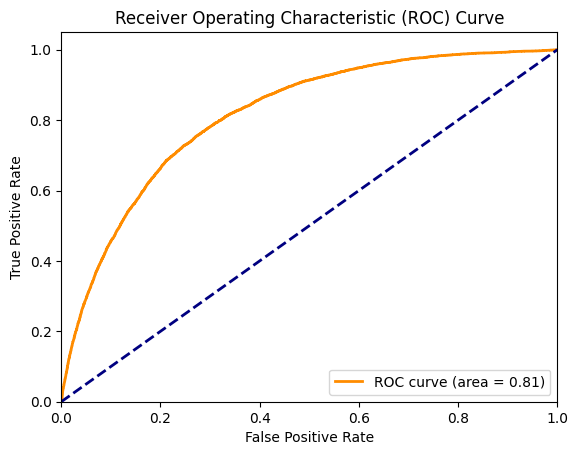

In [26]:
import matplotlib.pyplot as plt

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_test.numpy().flatten())
roc_auc = auc(fpr, tpr)

# Показ графика
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Линия случайного классификатора
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Многоклассовый классификатор

## Описание датасета

Согласно варианту в ходе работы используем датасет [«Оценка уровня физического развития людей разного возраста»](https://www.kaggle.com/datasets/kukuroo3/body-performance-data). В данном датасете людям выделяется 4 оценки физической активности: A,B,C,D. Именно эту оценку мы и будем предсказывать.

In [2]:
import kaggle

# Имя датасета
dataset_name = "kukuroo3/body-performance-data"

# Скачиваем и разархивируем в текущую папку
kaggle.api.dataset_download_files(dataset_name, path="./", unzip=True)


Dataset URL: https://www.kaggle.com/datasets/kukuroo3/body-performance-data


In [3]:
import pandas as pd

df = pd.read_csv('bodyPerformance.csv')
df.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


Перекодируем столбец "gender" на 1/0 вместо M/F. Для этого используем label encoder.

In [ ]:
from sklearn.preprocessing import LabelEncoder

print(df['gender'].unique())
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])
print(df['gender'].unique())

['M' 'F']
[1 0]


Таким образом получилось, что мужской пол кодируется единичкой, а женский - нулём. Не забудем про кодировку буквенных обозначений классов на численные:

In [5]:
from sklearn.preprocessing import LabelEncoder

print(df['class'].unique())
le2 = LabelEncoder()
df['class'] = le2.fit_transform(df['class'])
print(df['class'].unique())

['C' 'A' 'B' 'D']
[2 0 1 3]


Также как и в прошлый раз делим в соотношении 80/20

In [6]:
from sklearn.model_selection import train_test_split

y = df['class']
X = df.drop(['class'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print(f'X_train shape: {X_train.shape}\n y_train shape: {y_train.shape}\n X_test shape: {X_test.shape}\n y_test shape: {y_test.shape}')

X_train shape: (10714, 11)
 y_train shape: (10714,)
 X_test shape: (2679, 11)
 y_test shape: (2679,)


Здесь мы задаём fit у MinMaxScaler только на обучающей выборке, чтобы информация от тестовой выборки не просачилась в обучение.

In [7]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()

X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)


И собираем тензоры для PyTorch

In [8]:
import torch

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

## Создание модели

In [9]:
import torch

class Classifier(torch.nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(11, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 4)
        )
    
    def forward(self, x):
        return self.model(x)


## Обучение модели

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

batch_size = 32
num_epochs = 100
learning_rate = 0.001

model = Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        y_batch = y_batch.squeeze(dim=1).long()
        # Прямой проход
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        # Обратное распространение ошибки
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/100], Loss: 0.9717
Epoch [2/100], Loss: 0.8744
Epoch [3/100], Loss: 0.8305
Epoch [4/100], Loss: 0.8043
Epoch [5/100], Loss: 0.8923
Epoch [6/100], Loss: 0.8140
Epoch [7/100], Loss: 0.6526
Epoch [8/100], Loss: 1.0775
Epoch [9/100], Loss: 0.8632
Epoch [10/100], Loss: 0.7083
Epoch [11/100], Loss: 0.8704
Epoch [12/100], Loss: 0.8057
Epoch [13/100], Loss: 0.8706
Epoch [14/100], Loss: 1.0531
Epoch [15/100], Loss: 0.6078
Epoch [16/100], Loss: 0.6992
Epoch [17/100], Loss: 0.7881
Epoch [18/100], Loss: 0.5504
Epoch [19/100], Loss: 0.9260
Epoch [20/100], Loss: 0.5778
Epoch [21/100], Loss: 0.7109
Epoch [22/100], Loss: 0.4466
Epoch [23/100], Loss: 0.7244
Epoch [24/100], Loss: 0.6779
Epoch [25/100], Loss: 0.4812
Epoch [26/100], Loss: 0.7889
Epoch [27/100], Loss: 0.6330
Epoch [28/100], Loss: 0.5796
Epoch [29/100], Loss: 0.5891
Epoch [30/100], Loss: 0.4868
Epoch [31/100], Loss: 0.6092
Epoch [32/100], Loss: 0.4989
Epoch [33/100], Loss: 0.5937
Epoch [34/100], Loss: 0.7876
Epoch [35/100], Loss: 0

## Расчёт метрик

In [20]:
# Оценка точности модели на тестовом наборе данных
model.eval()  # Устанавливаем модель в режим оценки
correct = 0
total = 0

test_set = TensorDataset(X_test, y_test)

with torch.no_grad():  # Градиенты не нужны при оценке
    for X_batch, y_batch in test_set:  # data_loader - это DataLoader для тестовых данных
        y_batch = y_batch.long()  # Приводим к нужному типу
        y_pred = model(X_batch)  # Получаем предсказания (логиты)
        predicted_labels = torch.argmax(y_pred)  # Индекс с максимальным значением — это класс
        correct += (predicted_labels == y_batch).sum().item()
        total += y_batch.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 75.40%


# Регрессор

## Описание датасета

Согласно варианту в ходе работы используем датасет [«Wine Quality»](https://archive.ics.uci.edu/dataset/186/wine+quality). Этот набор данных содержит различные характеристики вина, а требуется предсказать полученное значение качества вина. 

In [1]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [144]:
import pandas as pd
from ucimlrepo import fetch_ucirepo

# Загружаем датасет
wine_quality = fetch_ucirepo(id=186)

# Преобразуем в DataFrame
df = pd.DataFrame(wine_quality.data.features, columns=wine_quality.metadata.features)
df['target'] = wine_quality.data.targets

# Проверяем результат
print(df.head())


   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  target  
0      9.4       5  
1      9.8       5  
2      9.8       5  
3 

In [145]:
import pandas as pd

# Предположим, что у вас уже есть DataFrame df
correlation_matrix = df.corr()

# Печать корреляционной матрицы
print(correlation_matrix)


                      fixed_acidity  volatile_acidity  citric_acid  \
fixed_acidity              1.000000          0.219008     0.324436   
volatile_acidity           0.219008          1.000000    -0.377981   
citric_acid                0.324436         -0.377981     1.000000   
residual_sugar            -0.111981         -0.196011     0.142451   
chlorides                  0.298195          0.377124     0.038998   
free_sulfur_dioxide       -0.282735         -0.352557     0.133126   
total_sulfur_dioxide      -0.329054         -0.414476     0.195242   
density                    0.458910          0.271296     0.096154   
pH                        -0.252700          0.261454    -0.329808   
sulphates                  0.299568          0.225984     0.056197   
alcohol                   -0.095452         -0.037640    -0.010493   
target                    -0.076743         -0.265699     0.085532   

                      residual_sugar  chlorides  free_sulfur_dioxide  \
fixed_acidity    

In [146]:
df.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'target'],
      dtype='object')

In [147]:
df['target'].unique()

array([5, 6, 7, 4, 8, 3, 9], dtype=int64)

In [148]:
from sklearn.model_selection import train_test_split

y = df['target']
X = df.drop(['target'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'X_train shape: {X_train.shape}\n y_train shape: {y_train.shape}\n X_test shape: {X_test.shape}\n y_test shape: {y_test.shape}')

X_train shape: (5197, 11)
 y_train shape: (5197,)
 X_test shape: (1300, 11)
 y_test shape: (1300,)


In [149]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()

X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

X_train_saved = X_train
X_test_saved = X_test
y_train_saved = y_train
y_test_saved = y_test

И собираем тензоры для PyTorch

In [150]:
import torch

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

## Модель регрессора

### Создание модели

In [140]:
import torch

class Regressor(torch.nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(11, 64),
            torch.nn.Linear(64, 128),
            torch.nn.Linear(128,256),
            torch.nn.Linear(256, 1)
        )
    
    def forward(self, x):
        return self.model(x)


### Обучение модели

Epoch [1/100], Train Loss: 1.2558, Test Loss: 0.5978
Epoch [2/100], Train Loss: 0.6064, Test Loss: 0.6703
Epoch [3/100], Train Loss: 0.5920, Test Loss: 0.6058
Epoch [4/100], Train Loss: 0.5759, Test Loss: 0.5699
Epoch [5/100], Train Loss: 0.5756, Test Loss: 1.3248
Epoch [6/100], Train Loss: 0.5901, Test Loss: 0.5908
Epoch [7/100], Train Loss: 0.5685, Test Loss: 0.5630
Epoch [8/100], Train Loss: 0.5725, Test Loss: 0.7263
Epoch [9/100], Train Loss: 0.5665, Test Loss: 0.5434
Epoch [10/100], Train Loss: 0.5664, Test Loss: 0.5895
Epoch [11/100], Train Loss: 0.5672, Test Loss: 0.5578
Epoch [12/100], Train Loss: 0.5644, Test Loss: 0.5433
Epoch [13/100], Train Loss: 0.5633, Test Loss: 0.6255
Epoch [14/100], Train Loss: 0.5683, Test Loss: 0.6218
Epoch [15/100], Train Loss: 0.5750, Test Loss: 0.5656
Epoch [16/100], Train Loss: 0.5691, Test Loss: 0.5448
Epoch [17/100], Train Loss: 0.5616, Test Loss: 0.8341
Epoch [18/100], Train Loss: 0.5716, Test Loss: 0.5467
Epoch [19/100], Train Loss: 0.5582, T

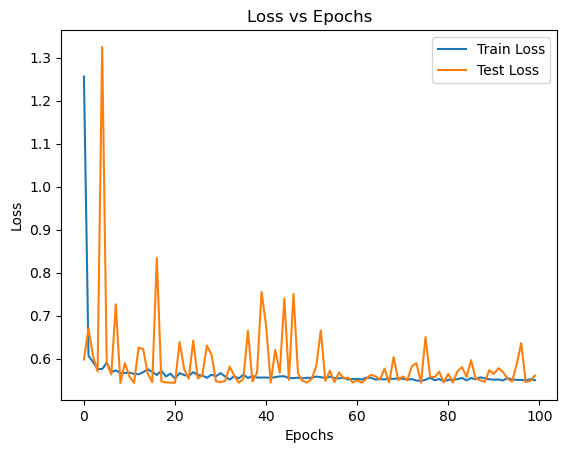

In [141]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

batch_size = 32
num_epochs = 100
learning_rate = 0.01

model = Regressor()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)  # Для тестовой выборки
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()  # Переводим модель в режим обучения
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        # Прямой проход
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        # Обратное распространение ошибки
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))  # Среднее значение потерь для тренировки

    # Оценка на тестовой выборке
    model.eval()  # Переводим модель в режим оценки (без градиентов)
    test_loss = 0.0
    with torch.no_grad():  # Не нужно вычислять градиенты
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            test_loss += loss.item()

    test_losses.append(test_loss / len(test_loader))  # Среднее значение потерь для теста

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

# Построение графика
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')
plt.show()


### Расчёт метрик

In [46]:
print(X_test.shape)
print(y_pred.shape)

torch.Size([1300, 11])
torch.Size([1300, 4])


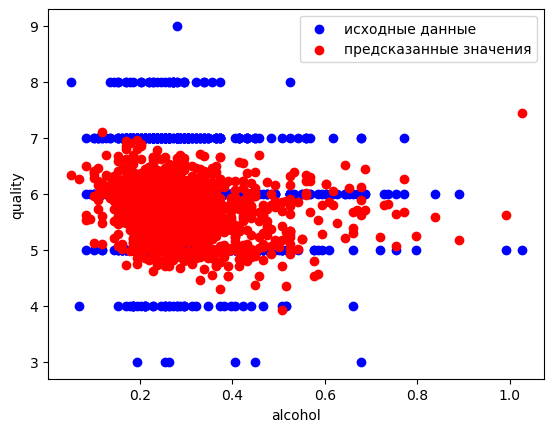

In [97]:
# Оценка точности модели на тестовом наборе данных
model.eval()  # Устанавливаем модель в режим оценки
correct = 0
total = 0


with torch.no_grad():  # Градиенты не нужны при оценке
    y_pred = model(X_test)  # Получаем предсказания

y_pred = pd.DataFrame(y_pred)

y_test.shape
X_test_saved = pd.DataFrame(X_test_saved)
a = X_test_saved[0].to_numpy()
plt.scatter(a, y_test, color = 'blue', label = 'исходные данные')
plt.scatter(a, y_pred, color = 'red', label = 'предсказанные значения')
plt.xlabel('alcohol')
plt.ylabel('quality')
plt.legend()
plt.show()

## Модель мультиклассовой классификатора из п2

### Создание модели

In [155]:
import torch

class Classifier(torch.nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(11, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 10)
        )
    
    def forward(self, x):
        return self.model(x)


### Обучение модели

In [156]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

batch_size = 32
num_epochs = 100
learning_rate = 0.001

model = Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        y_batch = y_batch.squeeze(dim=1).long()
        # Прямой проход
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        # Обратное распространение ошибки
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/100], Loss: 0.8991
Epoch [2/100], Loss: 0.8876
Epoch [3/100], Loss: 1.1635
Epoch [4/100], Loss: 1.1695
Epoch [5/100], Loss: 0.8004
Epoch [6/100], Loss: 1.1622
Epoch [7/100], Loss: 1.1267
Epoch [8/100], Loss: 0.6722
Epoch [9/100], Loss: 1.3558
Epoch [10/100], Loss: 1.0984
Epoch [11/100], Loss: 0.9319
Epoch [12/100], Loss: 0.8770
Epoch [13/100], Loss: 1.3232
Epoch [14/100], Loss: 1.2391
Epoch [15/100], Loss: 1.0238
Epoch [16/100], Loss: 1.0605
Epoch [17/100], Loss: 1.3780
Epoch [18/100], Loss: 0.8883
Epoch [19/100], Loss: 1.2132
Epoch [20/100], Loss: 1.1180
Epoch [21/100], Loss: 0.9301
Epoch [22/100], Loss: 0.9788
Epoch [23/100], Loss: 0.8468
Epoch [24/100], Loss: 1.2459
Epoch [25/100], Loss: 1.5259
Epoch [26/100], Loss: 1.6666
Epoch [27/100], Loss: 1.3714
Epoch [28/100], Loss: 0.8110
Epoch [29/100], Loss: 0.8815
Epoch [30/100], Loss: 1.1717
Epoch [31/100], Loss: 0.8280
Epoch [32/100], Loss: 0.7849
Epoch [33/100], Loss: 0.9179
Epoch [34/100], Loss: 1.1099
Epoch [35/100], Loss: 0

##№ Расчёт метрик

In [107]:
X_test.shape

torch.Size([1300, 11])

In [120]:
y_pred


tensor([5])

In [159]:
from torch.utils.data import DataLoader

# Устанавливаем модель в режим оценки
model.eval()

correct = 0
total = 0

# Создаем DataLoader для тестовых данных
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)

with torch.no_grad():  # Градиенты не нужны при оценке
    for X_batch, y_batch in test_loader:
        y_batch = y_batch.long()  # Приводим к нужному типу
        y_pred = model(X_batch)  # Получаем предсказания (логиты)
        _, predicted = torch.max(y_pred, 1)  # Получаем предсказанные метки классов
        
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

# Расчет точности
accuracy = correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 12.22%


In [160]:
from sklearn.metrics import classification_report, confusion_matrix

# Собираем все предсказания и истинные метки
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_batch = y_batch.long()
        y_pred = model(X_batch)
        _, predicted = torch.max(y_pred, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Выводим отчет о классификации
print(classification_report(all_labels, all_preds))

# Выводим матрицу ошибок
print(confusion_matrix(all_labels, all_preds))

              precision    recall  f1-score   support

           3       0.33      0.17      0.22         6
           4       0.27      0.09      0.14        43
           5       0.61      0.58      0.60       402
           6       0.58      0.73      0.65       597
           7       0.62      0.37      0.47       215
           8       0.38      0.08      0.14        36
           9       0.00      0.00      0.00         1

    accuracy                           0.59      1300
   macro avg       0.40      0.29      0.31      1300
weighted avg       0.58      0.59      0.57      1300

[[  1   1   2   2   0   0   0]
 [  1   4  23  15   0   0   0]
 [  1   9 235 150   6   1   0]
 [  0   1 121 438  34   3   0]
 [  0   0   3 131  80   1   0]
 [  0   0   0  25   8   3   0]
 [  0   0   0   0   1   0   0]]


c:\Users\Ruslan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ruslan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ruslan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Переворачиваем датасет, вводим t-sne

In [190]:
import pandas as pd
from ucimlrepo import fetch_ucirepo

# Загружаем датасет
wine_quality = fetch_ucirepo(id=186)

# Преобразуем в DataFrame
df = pd.DataFrame(wine_quality.data.features, columns=wine_quality.metadata.features)
df['target'] = wine_quality.data.targets

# Проверяем результат
print(df.head())


   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  target  
0      9.4       5  
1      9.8       5  
2      9.8       5  
3 

In [191]:
import pandas as pd

# Предположим, что у вас уже есть DataFrame df
correlation_matrix = df.corr()

# Печать корреляционной матрицы
print(correlation_matrix)


                      fixed_acidity  volatile_acidity  citric_acid  \
fixed_acidity              1.000000          0.219008     0.324436   
volatile_acidity           0.219008          1.000000    -0.377981   
citric_acid                0.324436         -0.377981     1.000000   
residual_sugar            -0.111981         -0.196011     0.142451   
chlorides                  0.298195          0.377124     0.038998   
free_sulfur_dioxide       -0.282735         -0.352557     0.133126   
total_sulfur_dioxide      -0.329054         -0.414476     0.195242   
density                    0.458910          0.271296     0.096154   
pH                        -0.252700          0.261454    -0.329808   
sulphates                  0.299568          0.225984     0.056197   
alcohol                   -0.095452         -0.037640    -0.010493   
target                    -0.076743         -0.265699     0.085532   

                      residual_sugar  chlorides  free_sulfur_dioxide  \
fixed_acidity    

In [192]:
df.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'target'],
      dtype='object')

In [193]:
df['target'].unique()
y = df['target']
X = df.drop(['target'], axis = 1)

In [194]:
y = df['target']
X = df.drop(['target'], axis = 1)

In [195]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
pca_result = pca.fit_transform(X)

for_looking = pd.DataFrame(pca_result.copy())
for_looking['target'] = y

# Предположим, что у вас уже есть DataFrame df
correlation_matrix = for_looking.corr()

# Печать корреляционной матрицы
print(correlation_matrix)


                   0             1             2             3             4  \
0       1.000000e+00  7.201372e-16 -1.180654e-16 -2.292693e-15  5.188208e-15   
1       7.201372e-16  1.000000e+00 -2.878675e-16  1.986293e-15 -6.315320e-15   
2      -1.180654e-16 -2.878675e-16  1.000000e+00  3.590913e-15 -3.910743e-15   
3      -2.292693e-15  1.986293e-15  3.590913e-15  1.000000e+00  1.284293e-13   
4       5.188208e-15 -6.315320e-15 -3.910743e-15  1.284293e-13  1.000000e+00   
target -3.541421e-02  1.249572e-01 -3.973930e-02 -2.693478e-01  3.692520e-01   

          target  
0      -0.035414  
1       0.124957  
2      -0.039739  
3      -0.269348  
4       0.369252  
target  1.000000  


In [196]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(pca_result, y, test_size=0.2, random_state=42)
print(f'X_train shape: {X_train.shape}\n y_train shape: {y_train.shape}\n X_test shape: {X_test.shape}\n y_test shape: {y_test.shape}')

X_train shape: (5197, 5)
 y_train shape: (5197,)
 X_test shape: (1300, 5)
 y_test shape: (1300,)


In [197]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()

X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

И собираем тензоры для PyTorch

In [198]:
import torch

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

## Модель регрессора

### Создание модели

In [199]:
import torch

class Regressor(torch.nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(5, 64),
            torch.nn.Linear(64, 128),
            torch.nn.Linear(128,256),
            torch.nn.Linear(256, 1)
        )
    
    def forward(self, x):
        return self.model(x)


### Обучение модели

Epoch [1/100], Train Loss: 1.2487, Test Loss: 0.6348
Epoch [2/100], Train Loss: 0.6402, Test Loss: 0.6023
Epoch [3/100], Train Loss: 0.6285, Test Loss: 0.6984
Epoch [4/100], Train Loss: 0.6316, Test Loss: 0.6126
Epoch [5/100], Train Loss: 0.6263, Test Loss: 0.6833
Epoch [6/100], Train Loss: 0.6156, Test Loss: 0.6556
Epoch [7/100], Train Loss: 0.6179, Test Loss: 0.7387
Epoch [8/100], Train Loss: 0.6171, Test Loss: 0.6098
Epoch [9/100], Train Loss: 0.6093, Test Loss: 0.6430
Epoch [10/100], Train Loss: 0.6198, Test Loss: 1.2189
Epoch [11/100], Train Loss: 0.6149, Test Loss: 0.6187
Epoch [12/100], Train Loss: 0.6145, Test Loss: 0.5933
Epoch [13/100], Train Loss: 0.6192, Test Loss: 0.6110
Epoch [14/100], Train Loss: 0.6130, Test Loss: 1.0360
Epoch [15/100], Train Loss: 0.6176, Test Loss: 0.6179
Epoch [16/100], Train Loss: 0.6232, Test Loss: 0.7202
Epoch [17/100], Train Loss: 0.6113, Test Loss: 1.0683
Epoch [18/100], Train Loss: 0.6183, Test Loss: 0.6512
Epoch [19/100], Train Loss: 0.6121, T

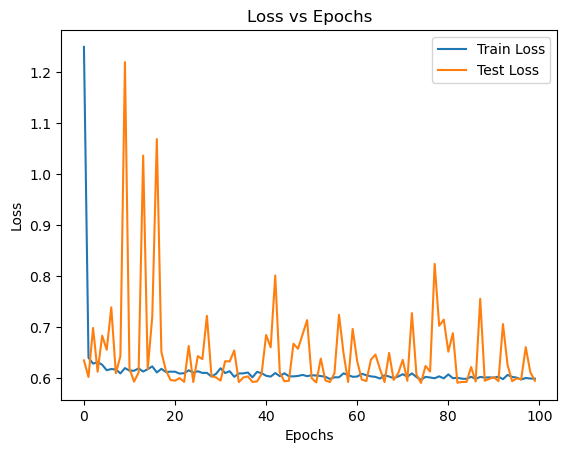

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

batch_size = 32
num_epochs = 100
learning_rate = 0.001

model = Regressor()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)  # Для тестовой выборки
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()  # Переводим модель в режим обучения
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        # Прямой проход
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        # Обратное распространение ошибки
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))  # Среднее значение потерь для тренировки

    # Оценка на тестовой выборке
    model.eval()  # Переводим модель в режим оценки (без градиентов)
    test_loss = 0.0
    with torch.no_grad():  # Не нужно вычислять градиенты
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            test_loss += loss.item()

    test_losses.append(test_loss / len(test_loader))  # Среднее значение потерь для теста

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

# Построение графика
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')
plt.show()


### Расчёт метрик

In [201]:
print(X_test.shape)
print(y_pred.shape)

torch.Size([1300, 5])
torch.Size([20, 1])


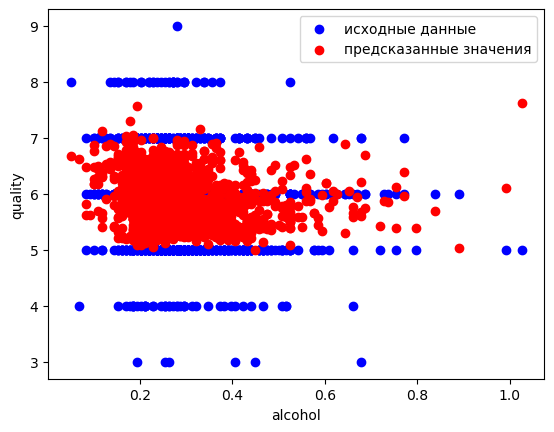

In [202]:
# Оценка точности модели на тестовом наборе данных
model.eval()  # Устанавливаем модель в режим оценки
correct = 0
total = 0


with torch.no_grad():  # Градиенты не нужны при оценке
    y_pred = model(X_test)  # Получаем предсказания

y_pred = pd.DataFrame(y_pred)

y_test.shape
X_test_saved = pd.DataFrame(X_test_saved)
a = X_test_saved[0].to_numpy()
plt.scatter(a, y_test, color = 'blue', label = 'исходные данные')
plt.scatter(a, y_pred, color = 'red', label = 'предсказанные значения')
plt.xlabel('alcohol')
plt.ylabel('quality')
plt.legend()
plt.show()

In [204]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

with torch.no_grad():  # Градиенты не нужны при оценке
    y_pred = model(X_test)  # Получаем предсказания

# Среднеквадратичная ошибка (MSE)
mse = mean_squared_error(y_test, y_pred)

# Средняя абсолютная ошибка (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Коэффициент детерминации (R²)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R²: {r2:.3f}")

MSE: 0.596
MAE: 0.601
R²: 0.193


## Модель мультиклассовой классификатора из п2

### Создание модели

In [183]:
import torch

class Classifier(torch.nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(5, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 10)
        )
    
    def forward(self, x):
        return self.model(x)


### Обучение модели

In [184]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

batch_size = 32
num_epochs = 100
learning_rate = 0.001

model = Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        y_batch = y_batch.squeeze(dim=1).long()
        # Прямой проход
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        # Обратное распространение ошибки
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/100], Loss: 2.0691
Epoch [2/100], Loss: 1.1413
Epoch [3/100], Loss: 1.2184
Epoch [4/100], Loss: 0.8312
Epoch [5/100], Loss: 1.2148
Epoch [6/100], Loss: 1.2982
Epoch [7/100], Loss: 1.0319
Epoch [8/100], Loss: 1.1000
Epoch [9/100], Loss: 1.0749
Epoch [10/100], Loss: 1.5104
Epoch [11/100], Loss: 1.2129
Epoch [12/100], Loss: 1.2526
Epoch [13/100], Loss: 1.0845
Epoch [14/100], Loss: 1.2730
Epoch [15/100], Loss: 1.3892
Epoch [16/100], Loss: 1.2794
Epoch [17/100], Loss: 1.1258
Epoch [18/100], Loss: 0.9083
Epoch [19/100], Loss: 1.2742
Epoch [20/100], Loss: 1.1813
Epoch [21/100], Loss: 0.8763
Epoch [22/100], Loss: 0.9205
Epoch [23/100], Loss: 1.0256
Epoch [24/100], Loss: 1.0587
Epoch [25/100], Loss: 1.2113
Epoch [26/100], Loss: 0.9443
Epoch [27/100], Loss: 1.1749
Epoch [28/100], Loss: 0.9566
Epoch [29/100], Loss: 1.2609
Epoch [30/100], Loss: 1.0620
Epoch [31/100], Loss: 1.4397
Epoch [32/100], Loss: 1.0390
Epoch [33/100], Loss: 1.2123
Epoch [34/100], Loss: 1.0293
Epoch [35/100], Loss: 1

### Расчёт метрик

In [ ]:
from torch.utils.data import DataLoader

# Устанавливаем модель в режим оценки
model.eval()

correct = 0
total = 0

# Создаем DataLoader для тестовых данных
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)

with torch.no_grad():  # Градиенты не нужны при оценке
    for X_batch, y_batch in test_loader:
        y_batch = y_batch.long()  # Приводим к нужному типу
        y_pred = model(X_batch)  # Получаем предсказания (логиты)
        _, predicted = torch.max(y_pred, 1)  # Получаем предсказанные метки классов
        
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

# Расчет точности
accuracy = correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

torch.Size([20, 5])
Test Accuracy: 12.38%


In [188]:
from sklearn.metrics import classification_report, confusion_matrix

# Собираем все предсказания и истинные метки
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_batch = y_batch.long()
        y_pred = model(X_batch)
        _, predicted = torch.max(y_pred, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Выводим отчет о классификации
print(classification_report(all_labels, all_preds))

# Выводим матрицу ошибок
print(confusion_matrix(all_labels, all_preds))

              precision    recall  f1-score   support

           3       0.33      0.17      0.22         6
           4       0.00      0.00      0.00        43
           5       0.55      0.67      0.60       402
           6       0.55      0.66      0.60       597
           7       0.53      0.20      0.30       215
           8       1.00      0.03      0.05        36
           9       0.00      0.00      0.00         1

    accuracy                           0.55      1300
   macro avg       0.42      0.25      0.25      1300
weighted avg       0.54      0.55      0.51      1300

[[  1   0   4   1   0   0   0]
 [  1   0  22  20   0   0   0]
 [  0   1 270 128   3   0   0]
 [  0   0 177 395  25   0   0]
 [  1   0  19 151  44   0   0]
 [  0   0   1  24  10   1   0]
 [  0   0   0   0   1   0   0]]


c:\Users\Ruslan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ruslan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ruslan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
